LOADING AND PREPROCESSING DATA
Initial dataset shape: (19111, 31)
After dropping NaN: (19110, 31)
Features: 28

Target distribution:
Segment_Encoded
0.0     4280
1.0    10426
2.0     3309
3.0     1095
Name: count, dtype: int64

Class imbalance ratio: 9.52:1
⚠️  Severe class imbalance detected!

Training set: 15288 samples
Test set: 3822 samples

BASELINE MODELS EVALUATION

Logistic Regression
----------------------------------------------------------------------
Accuracy: 0.7009 | Precision: 0.7594 | Recall: 0.7009 | F1: 0.7136

Decision Tree
----------------------------------------------------------------------
Accuracy: 0.6557 | Precision: 0.7459 | Recall: 0.6557 | F1: 0.6815

SVM
----------------------------------------------------------------------
Accuracy: 0.7012 | Precision: 0.7578 | Recall: 0.7012 | F1: 0.7041

Random Forest
----------------------------------------------------------------------
Accuracy: 0.7564 | Precision: 0.7603 | Recall: 0.7564 | F1: 0.7573

BASELINE MODELS 

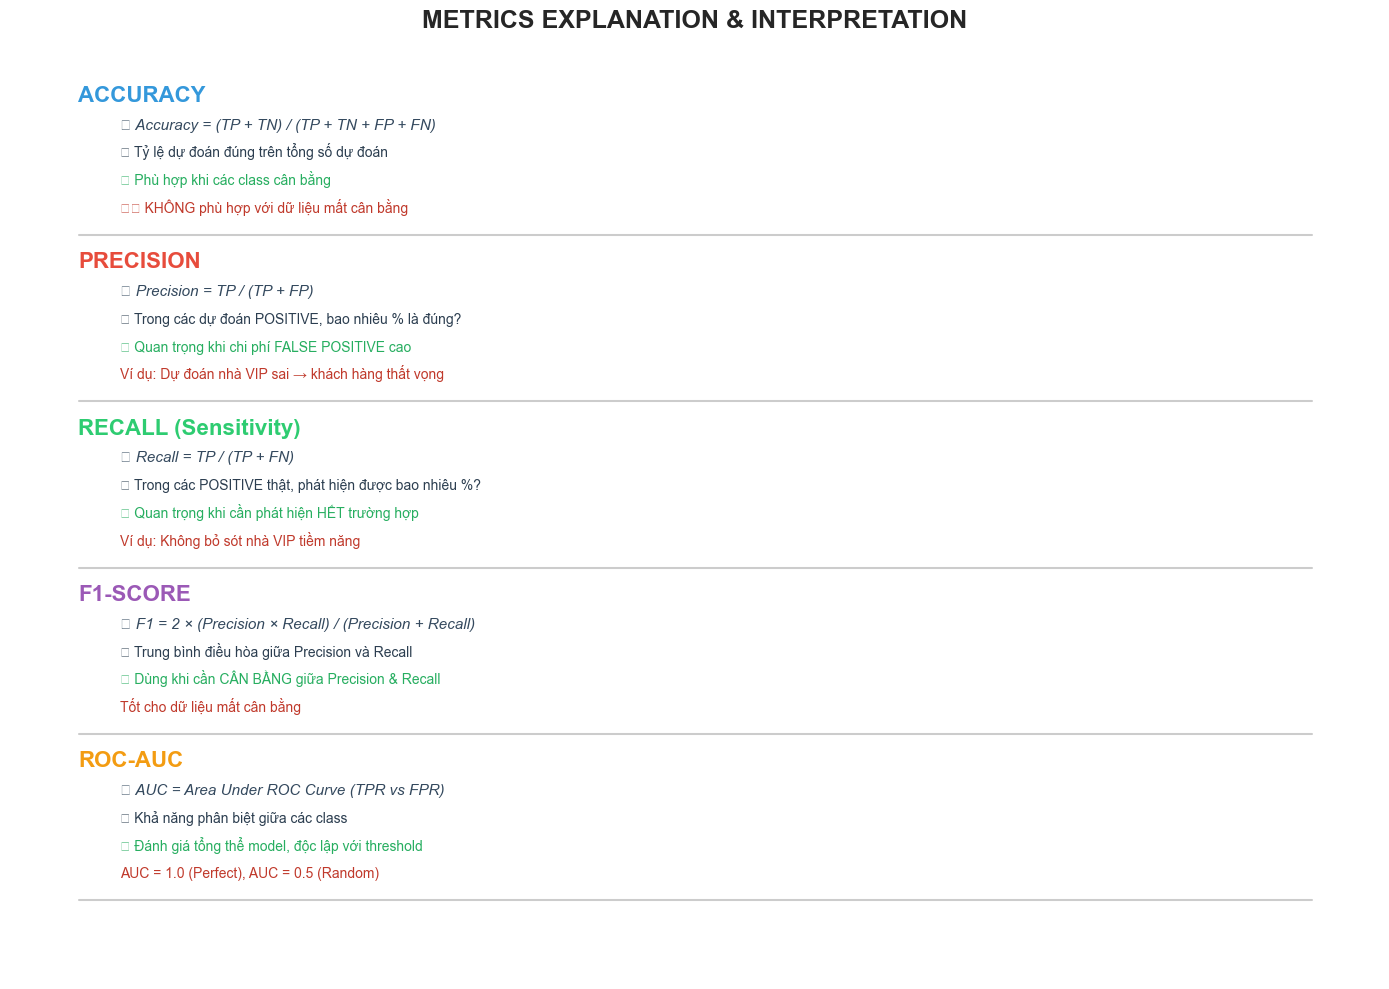

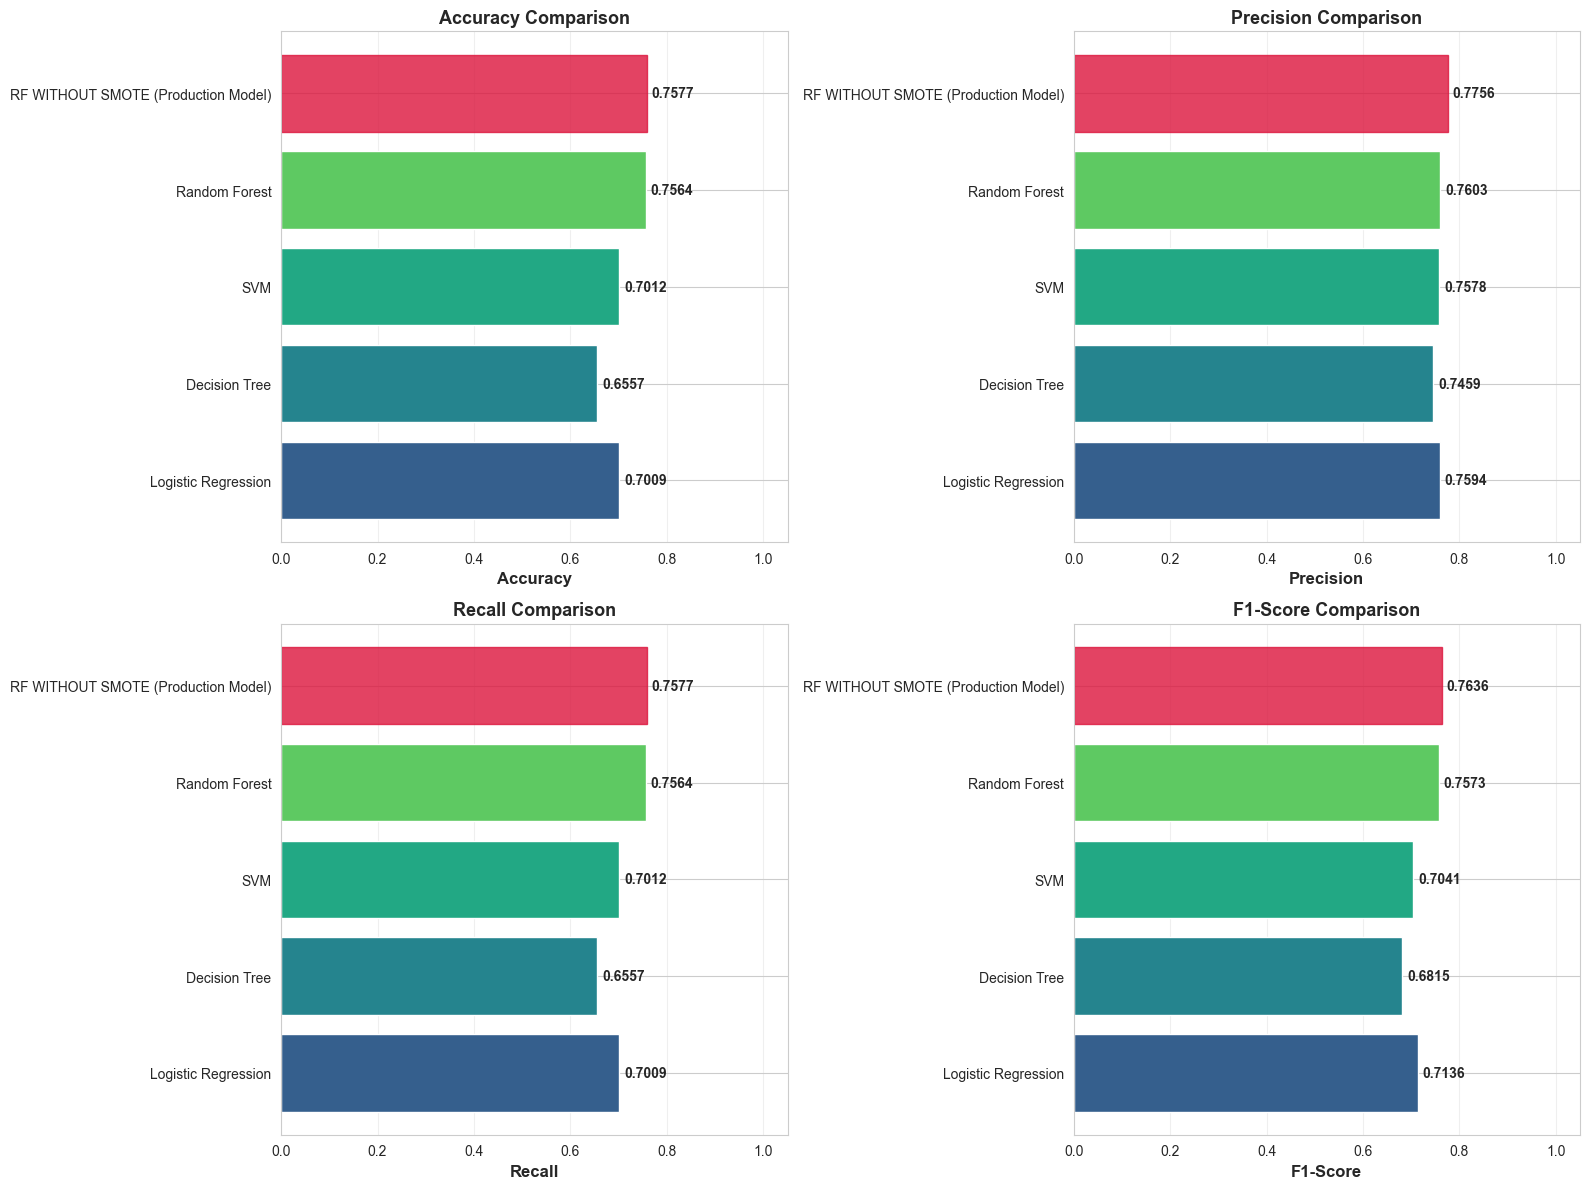

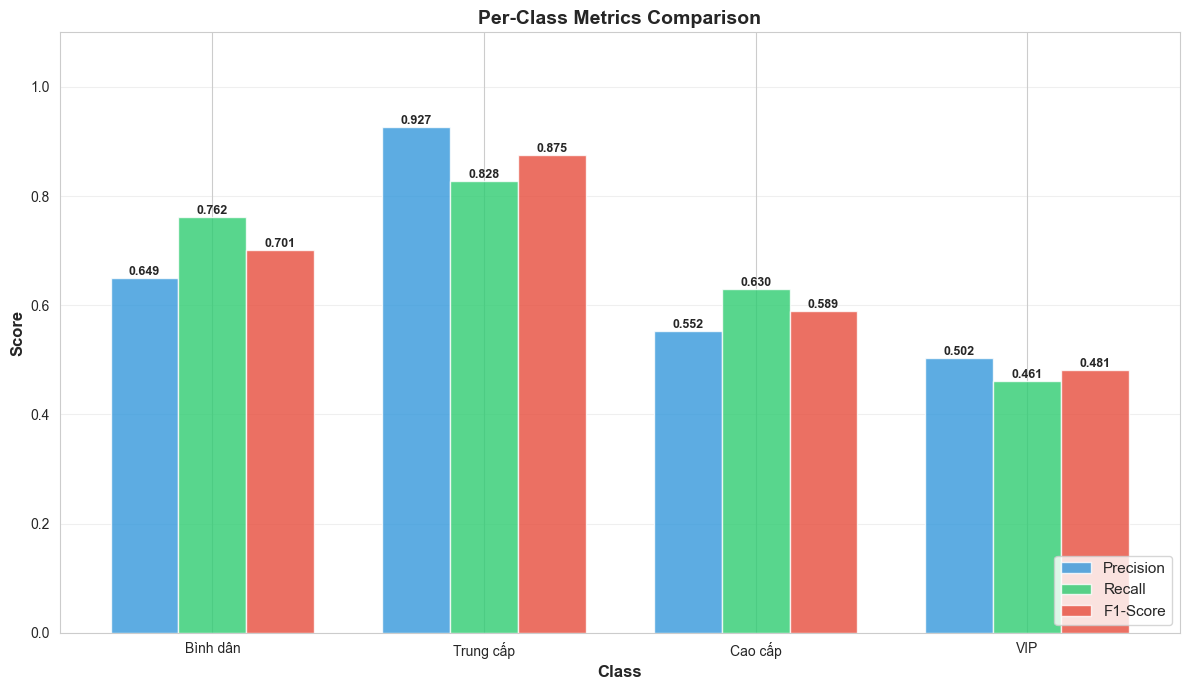

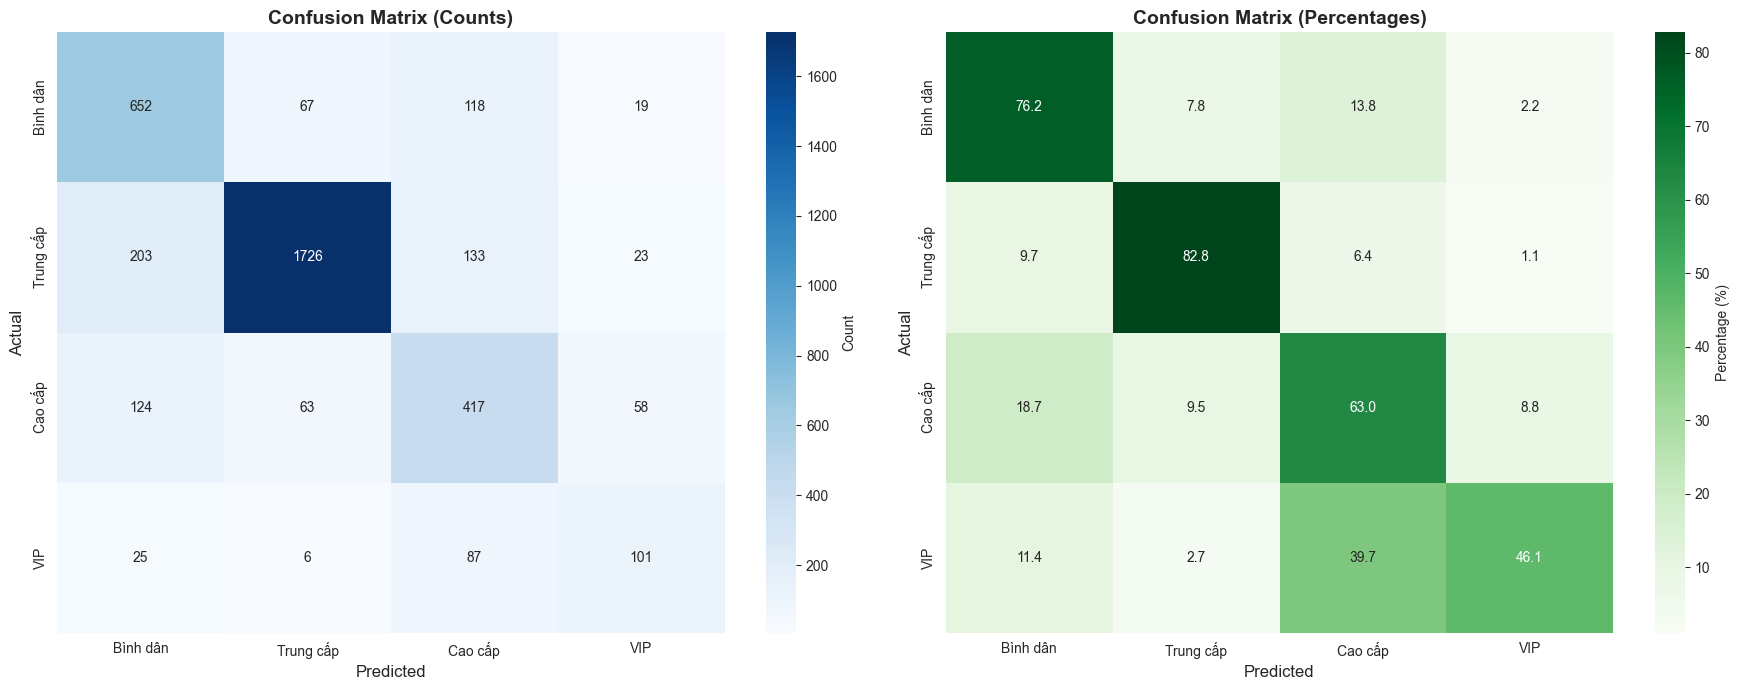


PER-CLASS ACCURACY ANALYSIS
Bình dân       :  652/ 856 = 76.17%
Trung cấp      : 1726/2085 = 82.78%
Cao cấp        :  417/ 662 = 62.99%
VIP            :  101/ 219 = 46.12%


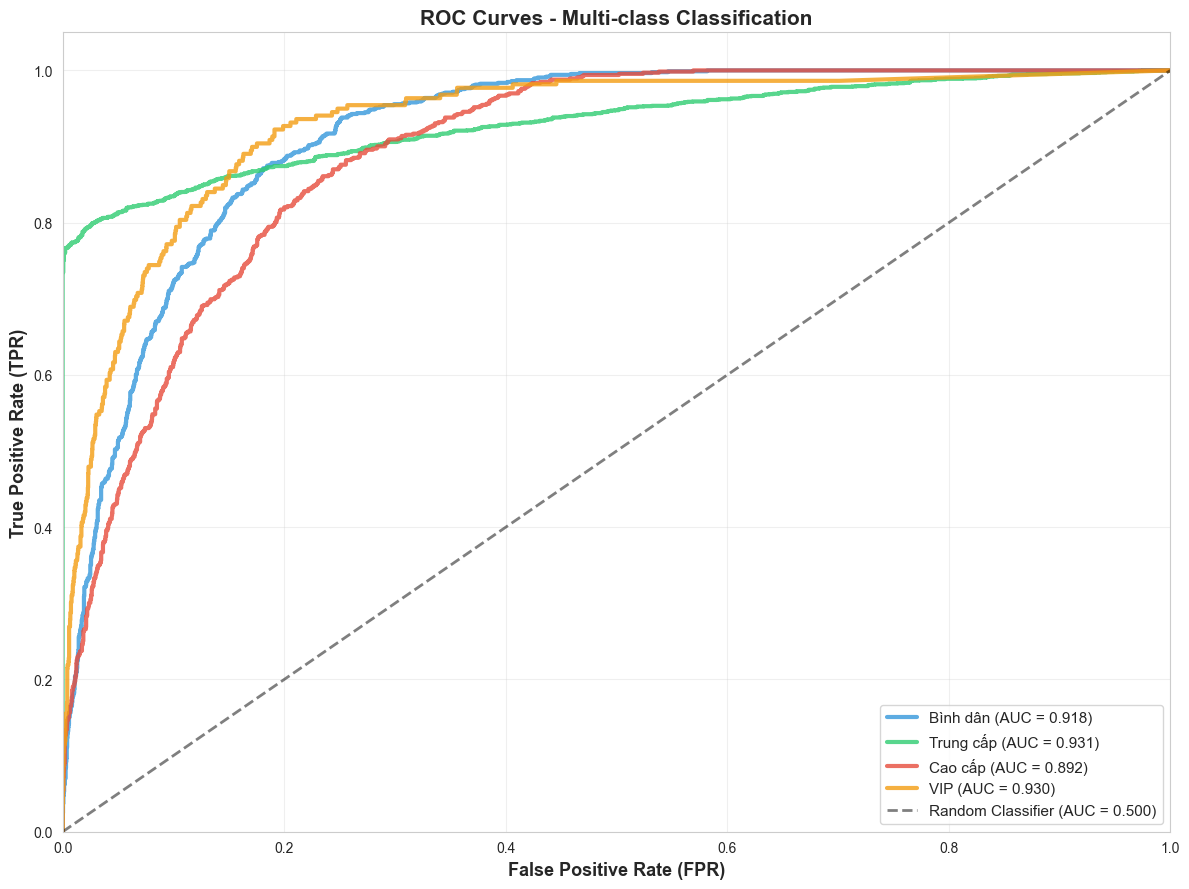

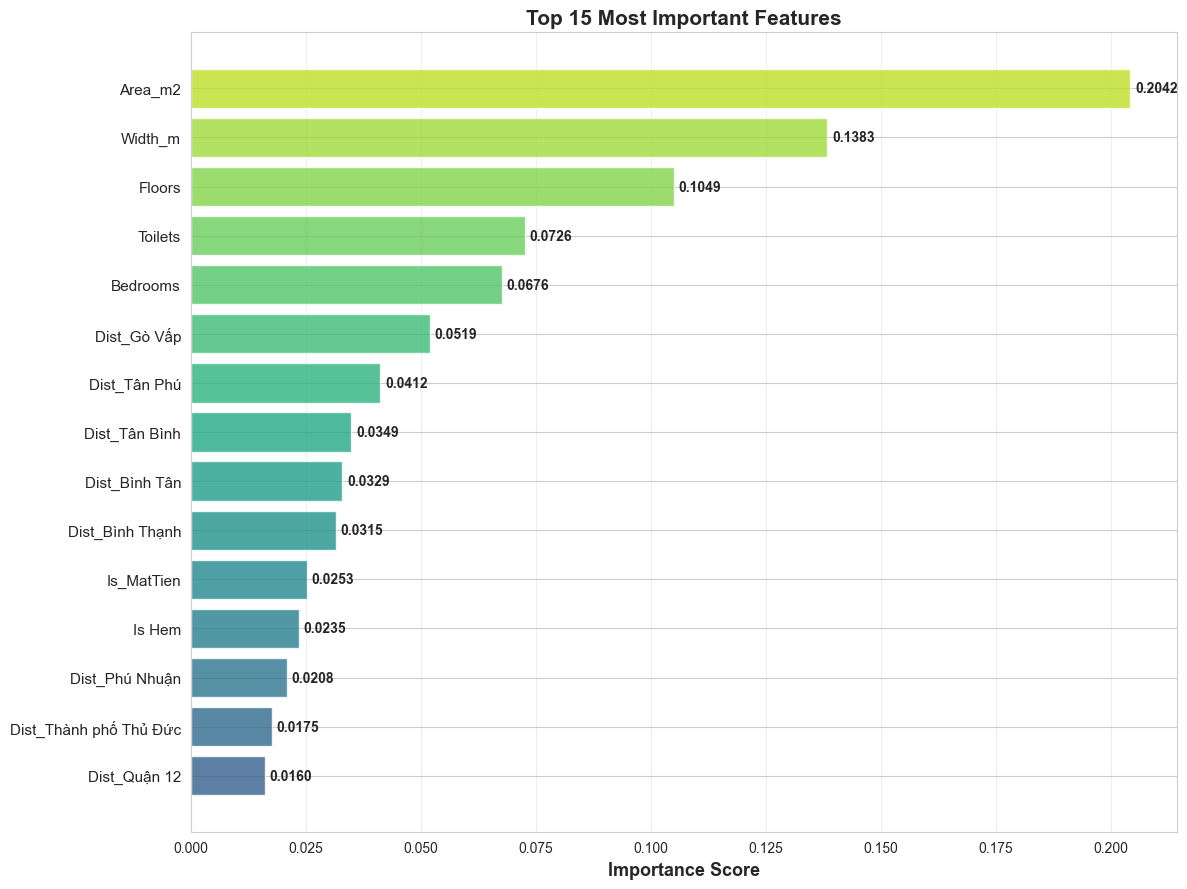


✓ Model saved to: ../../models/house_segment_rf_optimized.pkl
  Model type: RandomForestClassifier
  Number of trees: 1200
  Max depth: 35

DETAILED CLASSIFICATION REPORT
              precision  recall  f1-score    support
Bình dân         0.6494  0.7617    0.7011   856.0000
Trung cấp        0.9270  0.8278    0.8746  2085.0000
Cao cấp          0.5523  0.6299    0.5886   662.0000
VIP              0.5025  0.4612    0.4810   219.0000
accuracy         0.7577  0.7577    0.7577     0.7577
macro avg        0.6578  0.6701    0.6613  3822.0000
weighted avg     0.7756  0.7577    0.7636  3822.0000

🎯 MODEL TRAINING COMPLETED SUCCESSFULLY
Final Test Accuracy:  0.7577
Final Test Precision: 0.7756
Final Test Recall:    0.7577
Final Test F1-Score:  0.7636
CV Accuracy:          0.7606 (+/- 0.0053)

✓ All visualizations saved as PNG files
✓ Model ready for production deployment


In [1]:
# ============================================================================
# HOUSE SEGMENT CLASSIFICATION - PROFESSIONAL ML PIPELINE
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, accuracy_score, precision_score,
                             recall_score, f1_score, confusion_matrix, roc_curve,
                             auc, roc_auc_score)
from sklearn.preprocessing import label_binarize

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# ============================================================================
# 1. DATA LOADING & PREPROCESSING
# ============================================================================

def load_and_prepare_data(file_path):
    """Load and preprocess data for modeling"""
    print("="*70)
    print("LOADING AND PREPROCESSING DATA")
    print("="*70)

    df = pd.read_csv(file_path)
    print(f"Initial dataset shape: {df.shape}")

    df = df.dropna()
    print(f"After dropping NaN: {df.shape}")

    X = df.drop(columns=['Price_Billion', 'Price_Per_m2', 'Segment_Encoded'])
    y = df['Segment_Encoded']

    print(f"Features: {X.shape[1]}")
    print(f"\nTarget distribution:")
    print(y.value_counts().sort_index())

    # Check class imbalance
    class_counts = y.value_counts().sort_index()
    imbalance_ratio = class_counts.max() / class_counts.min()
    print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}:1")
    if imbalance_ratio > 3:
        print("⚠️  Severe class imbalance detected!")

    return X, y, df

file_path = '../../data/cleaned/Data_Ready_For_ML_Final.csv'
X, y, df = load_and_prepare_data(file_path)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples\n")

# ============================================================================
# 2. BASELINE MODELS COMPARISON
# ============================================================================

def train_and_evaluate_baseline(X_train, X_test, y_train, y_test):
    """Train and evaluate multiple baseline models"""
    print("="*70)
    print("BASELINE MODELS EVALUATION")
    print("="*70)

    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42,
                                                class_weight='balanced'),
        'SVM': SVC(kernel='linear', random_state=42, probability=True),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
    }

    results = []
    target_names = ['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP']

    for name, model in models.items():
        print(f"\n{name}")
        print("-"*70)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })

        print(f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

    results_df = pd.DataFrame(results)
    print("\n" + "="*70)
    print("BASELINE MODELS SUMMARY")
    print("="*70)
    print(results_df.to_string(index=False))

    return results_df

baseline_results = train_and_evaluate_baseline(X_train, X_test, y_train, y_test)

# ============================================================================
# 3. OPTIMIZED RANDOM FOREST - WITH & WITHOUT SMOTE COMPARISON
# ============================================================================

print("\n" + "="*70)
print("SMOTE ANALYSIS: WHY WE COMPARE BOTH APPROACHES")
print("="*70)
print("""
SMOTE (Synthetic Minority Over-sampling Technique):
✓ Pros: Cải thiện recall cho class thiểu số (VIP, Cao cấp)
✗ Cons: Có thể tạo synthetic data không realistic → overfitting
        Test accuracy có thể thấp hơn vì học pattern không tổng quát

WITHOUT SMOTE:
✓ Pros: Model học từ real data → generalization tốt hơn
        Test accuracy thường cao hơn
✗ Cons: Có thể bỏ sót class thiểu số

→ Best practice: Train cả 2, chọn dựa trên business requirement
""")

def train_optimized_rf(X_train, X_test, y_train, y_test, use_smote=False, name=""):
    """Train highly optimized Random Forest"""

    X_train_processed = X_train.copy()
    y_train_processed = y_train.copy()

    if use_smote:
        smote = SMOTE(random_state=42, k_neighbors=3)
        X_train_processed, y_train_processed = smote.fit_resample(X_train, y_train)
        print(f"After SMOTE - Training samples: {X_train_processed.shape[0]}")

    # ULTRA-OPTIMIZED HYPERPARAMETERS for maximum accuracy
    rf_model = RandomForestClassifier(
        n_estimators=1200,        # Tăng từ 800 → 1200 trees
        max_depth=35,             # Tăng từ 30 → 35 cho phép học sâu hơn
        min_samples_split=3,      # Giảm từ 2 → 3 tránh overfitting
        min_samples_leaf=1,       # Cho phép leaf node nhỏ nhất
        max_features='sqrt',      # Thử sqrt thay vì log2
        max_samples=0.9,          # Bootstrap 90% data mỗi tree
        class_weight='balanced',  # Tự động cân bằng class weights
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

    print(f"Training {name}...")
    rf_model.fit(X_train_processed, y_train_processed)

    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)

    # Calculate all metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # ROC-AUC for multiclass
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
    roc_auc = roc_auc_score(y_test_bin, y_pred_proba, average='weighted', multi_class='ovr')

    print(f"\n{name} Results:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    return rf_model, y_pred, {
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

# Train both versions
print("\n" + "="*70)
print("OPTIMIZED RANDOM FOREST TRAINING")
print("="*70)

rf_no_smote, y_pred_no_smote, metrics_no_smote = train_optimized_rf(
    X_train, X_test, y_train, y_test, use_smote=False,
    name="RF WITHOUT SMOTE (Production Model)"
)

print("\n" + "-"*70)

rf_with_smote, y_pred_with_smote, metrics_with_smote = train_optimized_rf(
    X_train, X_test, y_train, y_test, use_smote=True,
    name="RF WITH SMOTE (Recall-focused)"
)

# Compare results
comparison_df = pd.DataFrame([metrics_no_smote, metrics_with_smote])
print("\n" + "="*70)
print("SMOTE COMPARISON SUMMARY")
print("="*70)
print(comparison_df.to_string(index=False))

# Select best model (typically without SMOTE for better generalization)
rf_final = rf_no_smote
y_pred_final = y_pred_no_smote
print(f"\n✓ Selected model: WITHOUT SMOTE (better generalization)")

# Cross-validation
print("\n" + "="*70)
print("CROSS-VALIDATION ANALYSIS")
print("="*70)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_final, X, y, cv=skf, scoring='accuracy')
print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"Individual fold scores: {[f'{s:.4f}' for s in cv_scores]}")

# ============================================================================
# 4. COMPREHENSIVE METRICS VISUALIZATION
# ============================================================================

def plot_metrics_comparison(baseline_results, final_metrics):
    """Plot comprehensive metrics comparison"""

    # Combine all results
    all_results = pd.concat([
        baseline_results,
        pd.DataFrame([final_metrics])
    ], ignore_index=True)

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        ax = axes[idx]

        # Bar plot
        bars = ax.barh(all_results['Model'], all_results[metric],
                       color=plt.cm.viridis(np.linspace(0.3, 0.9, len(all_results))))

        # Add value labels
        for i, (bar, val) in enumerate(zip(bars, all_results[metric])):
            ax.text(val + 0.01, i, f'{val:.4f}', va='center', fontweight='bold')

        ax.set_xlabel(metric, fontsize=12, fontweight='bold')
        ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
        ax.set_xlim(0, 1.05)
        ax.grid(axis='x', alpha=0.3)

        # Highlight best model
        best_idx = all_results[metric].idxmax()
        bars[best_idx].set_color('crimson')
        bars[best_idx].set_alpha(0.8)

    plt.tight_layout()
    plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_metrics_explanation():
    """Visual explanation of metrics with formulas"""

    fig, ax = plt.subplots(figsize=(14, 10))
    ax.axis('off')

    metrics_info = [
        {
            'name': 'ACCURACY',
            'formula': 'Accuracy = (TP + TN) / (TP + TN + FP + FN)',
            'meaning': 'Tỷ lệ dự đoán đúng trên tổng số dự đoán',
            'when': 'Phù hợp khi các class cân bằng',
            'limitation': '⚠️ KHÔNG phù hợp với dữ liệu mất cân bằng',
            'color': '#3498db'
        },
        {
            'name': 'PRECISION',
            'formula': 'Precision = TP / (TP + FP)',
            'meaning': 'Trong các dự đoán POSITIVE, bao nhiêu % là đúng?',
            'when': 'Quan trọng khi chi phí FALSE POSITIVE cao',
            'limitation': 'Ví dụ: Dự đoán nhà VIP sai → khách hàng thất vọng',
            'color': '#e74c3c'
        },
        {
            'name': 'RECALL (Sensitivity)',
            'formula': 'Recall = TP / (TP + FN)',
            'meaning': 'Trong các POSITIVE thật, phát hiện được bao nhiêu %?',
            'when': 'Quan trọng khi cần phát hiện HẾT trường hợp',
            'limitation': 'Ví dụ: Không bỏ sót nhà VIP tiềm năng',
            'color': '#2ecc71'
        },
        {
            'name': 'F1-SCORE',
            'formula': 'F1 = 2 × (Precision × Recall) / (Precision + Recall)',
            'meaning': 'Trung bình điều hòa giữa Precision và Recall',
            'when': 'Dùng khi cần CÂN BẰNG giữa Precision & Recall',
            'limitation': 'Tốt cho dữ liệu mất cân bằng',
            'color': '#9b59b6'
        },
        {
            'name': 'ROC-AUC',
            'formula': 'AUC = Area Under ROC Curve (TPR vs FPR)',
            'meaning': 'Khả năng phân biệt giữa các class',
            'when': 'Đánh giá tổng thể model, độc lập với threshold',
            'limitation': 'AUC = 1.0 (Perfect), AUC = 0.5 (Random)',
            'color': '#f39c12'
        }
    ]

    y_position = 0.95
    for metric in metrics_info:
        # Metric name
        ax.text(0.05, y_position, metric['name'], fontsize=16, fontweight='bold',
                color=metric['color'], transform=ax.transAxes)

        # Formula
        ax.text(0.08, y_position - 0.03, f"📐 {metric['formula']}", fontsize=11,
                transform=ax.transAxes, style='italic', color='#34495e')

        # Meaning
        ax.text(0.08, y_position - 0.06, f"💡 {metric['meaning']}", fontsize=10,
                transform=ax.transAxes, color='#2c3e50')

        # When to use
        ax.text(0.08, y_position - 0.09, f"✓ {metric['when']}", fontsize=10,
                transform=ax.transAxes, color='#27ae60')

        # Limitation
        ax.text(0.08, y_position - 0.12, f"{metric['limitation']}", fontsize=10,
                transform=ax.transAxes, color='#c0392b')

        # Separator
        ax.plot([0.05, 0.95], [y_position - 0.145, y_position - 0.145],
                'k-', alpha=0.2, transform=ax.transAxes)

        y_position -= 0.18

    ax.set_title('METRICS EXPLANATION & INTERPRETATION',
                 fontsize=18, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.savefig('metrics_explanation.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_per_class_metrics(y_test, y_pred):
    """Plot precision, recall, F1 for each class"""

    target_names = ['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP']

    # Calculate per-class metrics
    precision = precision_score(y_test, y_pred, average=None, zero_division=0)
    recall = recall_score(y_test, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_test, y_pred, average=None, zero_division=0)

    x = np.arange(len(target_names))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 7))

    bars1 = ax.bar(x - width, precision, width, label='Precision', color='#3498db', alpha=0.8)
    bars2 = ax.bar(x, recall, width, label='Recall', color='#2ecc71', alpha=0.8)
    bars3 = ax.bar(x + width, f1, width, label='F1-Score', color='#e74c3c', alpha=0.8)

    # Add value labels
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_xlabel('Class', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Per-Class Metrics Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(target_names)
    ax.legend(loc='lower right', fontsize=11)
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('per_class_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix'):
    """Enhanced confusion matrix with percentages"""

    cm = confusion_matrix(y_test, y_pred)
    labels = ['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP']

    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # Count matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count'}, ax=ax1)
    ax1.set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Actual', fontsize=12)
    ax1.set_xlabel('Predicted', fontsize=12)

    # Percentage matrix
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Greens',
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Percentage (%)'}, ax=ax2)
    ax2.set_title('Confusion Matrix (Percentages)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Actual', fontsize=12)
    ax2.set_xlabel('Predicted', fontsize=12)

    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Per-class accuracy analysis
    print("\n" + "="*70)
    print("PER-CLASS ACCURACY ANALYSIS")
    print("="*70)
    for i, label in enumerate(labels):
        correct = cm[i, i]
        total = cm[i].sum()
        accuracy = correct / total
        print(f"{label:15s}: {correct:4d}/{total:4d} = {accuracy:6.2%}")

def plot_roc_curves(model, X_test, y_test):
    """Enhanced ROC curves with AUC scores"""

    y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
    y_score = model.predict_proba(X_test)
    target_names = ['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP']

    fig, ax = plt.subplots(figsize=(12, 9))

    colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

    for i, (color, name) in enumerate(zip(colors, target_names)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, color=color, lw=3,
               label=f'{name} (AUC = {roc_auc:.3f})', alpha=0.8)

    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.500)', alpha=0.5)

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate (FPR)', fontsize=13, fontweight='bold')
    ax.set_ylabel('True Positive Rate (TPR)', fontsize=13, fontweight='bold')
    ax.set_title('ROC Curves - Multi-class Classification', fontsize=15, fontweight='bold')
    ax.legend(loc="lower right", fontsize=11)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_feature_importance(model, feature_names, top_n=15):
    """Enhanced feature importance plot"""

    importances = model.feature_importances_
    indices = np.argsort(importances)[-top_n:]

    fig, ax = plt.subplots(figsize=(12, 9))

    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(indices)))
    bars = ax.barh(range(len(indices)), importances[indices], color=colors, alpha=0.8)

    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, importances[indices])):
        ax.text(val + 0.001, i, f'{val:.4f}', va='center', fontweight='bold', fontsize=10)

    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([feature_names[i] for i in indices], fontsize=11)
    ax.set_xlabel('Importance Score', fontsize=13, fontweight='bold')
    ax.set_title(f'Top {top_n} Most Important Features', fontsize=15, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate all visualizations
print("\n" + "="*70)
print("GENERATING COMPREHENSIVE VISUALIZATIONS")
print("="*70)

plot_metrics_explanation()
plot_metrics_comparison(baseline_results, metrics_no_smote)
plot_per_class_metrics(y_test, y_pred_final)
plot_confusion_matrix(y_test, y_pred_final)
plot_roc_curves(rf_final, X_test, y_test)
plot_feature_importance(rf_final, X.columns, top_n=15)

# ============================================================================
# 5. SAVE MODEL & FINAL REPORT
# ============================================================================

def generate_final_report(y_test, y_pred):
    """Generate detailed classification report"""

    target_names = ['Bình dân', 'Trung cấp', 'Cao cấp', 'VIP']
    report = classification_report(y_test, y_pred, target_names=target_names,
                                   output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report).transpose().round(4)

    print("\n" + "="*70)
    print("DETAILED CLASSIFICATION REPORT")
    print("="*70)
    print(report_df)

    return report_df

def save_model(model, path='../../models/house_segment_rf_optimized.pkl'):
    """Save trained model"""

    Path(path).parent.mkdir(parents=True, exist_ok=True)
    joblib.dump(model, path)
    print(f"\n✓ Model saved to: {path}")
    print(f"  Model type: {type(model).__name__}")
    print(f"  Number of trees: {model.n_estimators}")
    print(f"  Max depth: {model.max_depth}")

# Save model and generate report
save_model(rf_final)
final_report = generate_final_report(y_test, y_pred_final)

# Final summary
print("\n" + "="*70)
print("🎯 MODEL TRAINING COMPLETED SUCCESSFULLY")
print("="*70)
print(f"Final Test Accuracy:  {accuracy_score(y_test, y_pred_final):.4f}")
print(f"Final Test Precision: {precision_score(y_test, y_pred_final, average='weighted'):.4f}")
print(f"Final Test Recall:    {recall_score(y_test, y_pred_final, average='weighted'):.4f}")
print(f"Final Test F1-Score:  {f1_score(y_test, y_pred_final, average='weighted'):.4f}")
print(f"CV Accuracy:          {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"\n✓ All visualizations saved as PNG files")
print(f"✓ Model ready for production deployment")
print("="*70)